## Import

In [1]:
import torch
from tqdm import tqdm_notebook as tqdm

from transformers import BertTokenizer, BertModel, BertForMaskedLM

I0723 08:25:38.470734 140283865257792 file_utils.py:39] PyTorch version 1.1.0 available.


In [2]:
import pandas as pd
import numpy as np

In [3]:
from torch.nn.utils.rnn import pad_sequence 
import torchvision
import torch.nn as nn

In [4]:
from transformers.optimization import AdamW
from transformers.optimization import AdamW, get_linear_schedule_with_warmup

In [5]:
validation_data = pd.read_json("FGC_release_1.7.13/FGC_release_all_dev.json")
training_data = pd.read_json("FGC_release_1.7.13/FGC_release_all_train.json")
test_data = pd.read_json("FGC_release_1.7.13/FGC_release_all_test.json")

In [6]:
device = torch.device("cuda")

## Data Preprocessing

In [7]:
def datapreprocessing(data, return_df=False):
    
    # Save all the questions, potential supporting evidence and indices in three lists
    textQ_to_be_tokenized = []
    textA_to_be_tokenized = []
    sp_index = []
    max_counter = 0
    for dictionary in data['QUESTIONS']:
        for element in dictionary:
            textQ_to_be_tokenized.append(element['QTEXT_CN'])
            sp_index.append(element['SHINT_'])
    for dictionary in data['SENTS']:
        current_text_sentence = []
        for element in dictionary:
            current_text_sentence.append(element['text'])
        textA_to_be_tokenized.append(current_text_sentence)
    
    QandA_label = pd.DataFrame({'Question': textQ_to_be_tokenized,
                                'Sentence_List': textA_to_be_tokenized,
                                'SE_Index': sp_index,
                                'Label': sp_index})

    QandA_label['Length'] = QandA_label['Sentence_List'].apply(lambda x: len(x))
    QandA_label['SE_Index'] = QandA_label['SE_Index'].apply(lambda x: [0])
    QandA_label['SE_Index'] = QandA_label['SE_Index'] * QandA_label['Length']
    QandA_label['SE_Index'] = list(zip(QandA_label['SE_Index'], QandA_label['Label']))

    # Extract label index
    for row in QandA_label['SE_Index']:
        for index in row[1]:
            row[0][index] = 1
        
    indexed = [i[0] for i in list(QandA_label['SE_Index'])]
    QandA_label['Label'] = indexed

    if return_df:
        return QandA_label
    
    Q_and_Sentence_all_Comb = pd.DataFrame({'Question':np.repeat(QandA_label['Question'].values, QandA_label['Sentence_List'].str.len()),
                        'Sentence':np.concatenate(QandA_label['Sentence_List'].values)})
    Q_and_Sentence_all_Comb['Label'] = QandA_label['Label'].sum()
    
    tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
            
    # Put all question and sentence combination into a list 
    All_instances = []
    for i in range(len(QandA_label)):
        for sentence in QandA_label['Sentence_List'][i]:
            question_token = tokenizer.tokenize(QandA_label['Question'][i])
            sentence_token = tokenizer.tokenize(sentence)
            instance = ['[CLS]'] + question_token + ['[SEP]'] + sentence_token + ['[SEP]']
            
            if len(instance) > 200:
                instance = instance[:200]
                max_counter += 1
            
            #instance = instance[:100]
            All_instances.append(instance)
            
    # Convert ids to segment_ids
    segment_ids = []
    for token in All_instances:
        length_of_zeros = token.index('[SEP]') - token.index('[CLS]') + 1
        length_of_ones = len(token) - length_of_zeros
        zeros_and_ones = [0] * length_of_zeros + [1] * length_of_ones
        segment_ids.append(zeros_and_ones)
        
    ids = []
    for token in All_instances:
        ids.append(tokenizer.convert_tokens_to_ids(token))
        
    mask_ids = []
    for token in All_instances:
        mask_ids.append([1] * len(token))
        
    labels = list(Q_and_Sentence_all_Comb['Label'])
    labels = [[i] for i in labels]
    return All_instances, ids, segment_ids, mask_ids, labels

In [8]:
"""
def window_sentence_preprocessing(data, all_instances, labs, number_of_sentences):
        
    len_array = np.cumsum(np.array(data['SENTS'].apply(lambda x: len(x))))
    tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

    ids = []
    segment_ids = []
    mask_ids = []
    labels = []
    ids_subunit = []
    segment_ids_subunit = []
    mask_ids_subunit = []
    labels_subunit = []
    unit_counter = 0
    
    for count, token in enumerate(all_instances, 1):
        # Append ids
        ids_subunit.append(tokenizer.convert_tokens_to_ids(token))
        
        # Append segment ids
        length_of_zeros = token.index('[SEP]') - token.index('[CLS]') + 1
        length_of_ones = len(token) - length_of_zeros
        zeros_and_ones = [0] * length_of_zeros + [1] * length_of_ones
        segment_ids_subunit.append(zeros_and_ones)
        
        # Append mask ids
        mask_ids_subunit.append([1] * len(token))
        
        unit_counter += 1
        
        if bool(unit_counter % number_of_sentences == 0) or bool(count in len_array):
            
            ids.append(ids_subunit)
            segment_ids.append(segment_ids_subunit)
            mask_ids.append(mask_ids_subunit)
            
            ids_subunit = []
            segment_ids_subunit = []
            mask_ids_subunit = []
            unit_counter = 0
    
    label_counter = 0
    # Append labels
    for count, label in enumerate(labs, 1):
        
        labels_subunit.append(label)
        label_counter += 1
        
        if bool(label_counter % number_of_sentences == 0) or bool(count in len_array): 
            
            labels.append(labels_subunit)
            labels_subunit = []
            label_counter = 0
    
            
    return ids, segment_ids, mask_ids, labels"""

"\ndef window_sentence_preprocessing(data, all_instances, labs, number_of_sentences):\n        \n    len_array = np.cumsum(np.array(data['SENTS'].apply(lambda x: len(x))))\n    tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')\n\n    ids = []\n    segment_ids = []\n    mask_ids = []\n    labels = []\n    ids_subunit = []\n    segment_ids_subunit = []\n    mask_ids_subunit = []\n    labels_subunit = []\n    unit_counter = 0\n    \n    for count, token in enumerate(all_instances, 1):\n        # Append ids\n        ids_subunit.append(tokenizer.convert_tokens_to_ids(token))\n        \n        # Append segment ids\n        length_of_zeros = token.index('[SEP]') - token.index('[CLS]') + 1\n        length_of_ones = len(token) - length_of_zeros\n        zeros_and_ones = [0] * length_of_zeros + [1] * length_of_ones\n        segment_ids_subunit.append(zeros_and_ones)\n        \n        # Append mask ids\n        mask_ids_subunit.append([1] * len(token))\n        \n        unit_count

In [9]:

def window_sentence_preprocessing(data, dataset, number_of_sentences):
    
    len_array = np.cumsum(np.array(data['SENTS'].apply(lambda x: len(x))))
    dictionary_lists = []
    batches = []
    
    unit_counter = 0
    for count, instance in enumerate(dataset, 1):
        
        dictionary_lists.append(instance)
        unit_counter += 1
        
        if (unit_counter % number_of_sentences == 0) or (count in len_array):
            
            padded_ids = pad_sequence([torch.tensor(instance['ids']) for instance in dictionary_lists], batch_first=True)
            padded_ids = padded_ids.to(device)

            padded_segment_ids = pad_sequence([torch.tensor(instance['segment_ids']) for instance in dictionary_lists], batch_first=True)
            padded_segment_ids = padded_segment_ids.to(device)

            padded_mask_ids = pad_sequence([torch.tensor(instance['mask_ids']) for instance in dictionary_lists], batch_first=True)
            padded_mask_ids = padded_mask_ids.to(device)

            labels = torch.stack([torch.tensor(instance['labels']) for instance in dictionary_lists])
            labels = labels.to(device)

            current_dev_batch = {'ids': padded_ids, 'mask_ids': padded_mask_ids, 'segment_ids': padded_segment_ids, 'labels': labels}

            batches.append(current_dev_batch)
            dictionary_lists = []
            unit_counter = 0
    
    return batches


In [10]:
def eval_preprocessing(data, dataset):
    
    len_array = np.cumsum(np.array(data['SENTS'].apply(lambda x: len(x))))

    dictionary_lists = []
    batches = []
    for i in range(len(dataset.instances)):

        instance = dataset.instances[i]
        dictionary_lists.append(instance)
        
        if i in len_array - 1:

            padded_ids = pad_sequence([torch.tensor(instance['ids']) for instance in dictionary_lists], batch_first=True)
            padded_ids = padded_ids.to(device)

            padded_segment_ids = pad_sequence([torch.tensor(instance['segment_ids']) for instance in dictionary_lists], batch_first=True)
            padded_segment_ids = padded_segment_ids.to(device)

            padded_mask_ids = pad_sequence([torch.tensor(instance['mask_ids']) for instance in dictionary_lists], batch_first=True)
            padded_mask_ids = padded_mask_ids.to(device)

            labels = torch.stack([torch.tensor(instance['labels']) for instance in dictionary_lists])
            labels = labels.to(device)

            current_dev_batch = {'ids': padded_ids, 'mask_ids': padded_mask_ids, 'segment_ids': padded_segment_ids, 'labels': labels}

            batches.append(current_dev_batch)
            dictionary_lists = []

    return batches

In [11]:
dev_instances, dev_ids, dev_seg_ids, dev_mask_ids, dev_labels = datapreprocessing(validation_data)
train_instances, train_ids, train_seg_ids, train_mask_ids, train_labels = datapreprocessing(training_data)
test_instances, test_ids, test_seg_ids, test_mask_ids, test_labels = datapreprocessing(test_data)

I0723 08:25:42.386647 140283865257792 tokenization_utils.py:375] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-vocab.txt from cache at /root/.cache/torch/transformers/8a0c070123c1f794c42a29c6904beb7c1b8715741e235bee04aca2c7636fc83f.9b42061518a39ca00b8b52059fd2bede8daa613f8a8671500e518a8c29de8c00
I0723 08:25:47.220201 140283865257792 tokenization_utils.py:375] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-vocab.txt from cache at /root/.cache/torch/transformers/8a0c070123c1f794c42a29c6904beb7c1b8715741e235bee04aca2c7636fc83f.9b42061518a39ca00b8b52059fd2bede8daa613f8a8671500e518a8c29de8c00
I0723 08:26:05.825831 140283865257792 tokenization_utils.py:375] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-vocab.txt from cache at /root/.cache/torch/transformers/8a0c070123c1f794c42a29c6904beb7c1b8715741e235bee04aca2c7636fc83f.9b42061518a39ca00b8b52059fd2bede8daa613f8a8671500e518a8c29de8c0

## Loading Data

In [12]:
from torch.utils.data import Dataset

In [13]:
class SentenceDataset(Dataset):
    
    def __init__(self, ids, segment_ids, mask_ids, labels):
        self.instances = []
        for ids_i, segment_ids_i, mask_ids, label in zip(ids, segment_ids, mask_ids, labels):
            self.instances.append({"ids": ids_i, "segment_ids": segment_ids_i, 
                                   "mask_ids": mask_ids, "labels": label})  
    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx):
        sample = self.instances[idx]

        return sample

In [14]:
train_dataset = SentenceDataset(train_ids, train_seg_ids, train_mask_ids, train_labels)

In [15]:
dev_dataset = SentenceDataset(dev_ids, dev_seg_ids, dev_mask_ids, dev_labels)

In [16]:
test_dataset = SentenceDataset(test_ids, test_seg_ids, test_mask_ids, test_labels)

In [17]:
from torch.utils.data import DataLoader

In [18]:
def collate(batch):
    padded_ids = pad_sequence([torch.tensor(instance['ids']) for instance in batch], batch_first=True)
    padded_ids = padded_ids.to(device)
    
    padded_segment_ids = pad_sequence([torch.tensor(instance['segment_ids']) for instance in batch], batch_first=True)
    padded_segment_ids = padded_segment_ids.to(device)
    
    padded_mask_ids = pad_sequence([torch.tensor(instance['mask_ids']) for instance in batch], batch_first=True)
    padded_mask_ids = padded_mask_ids.to(device)
    
    labels = torch.stack([torch.tensor(instance['labels']) for instance in batch])
    labels = labels.to(device)
    return {'ids': padded_ids, 'mask_ids': padded_mask_ids, 'segment_ids': padded_segment_ids, 'labels': labels}

In [19]:
def collate_3d(batch):
    
    batch_size = len(batch)
    max_num_sentences, max_sentence_length = find_max_dimension(batch)
    target_ids = torch.zeros(batch_size, max_num_sentences, max_sentence_length)
    target_segment_ids = torch.zeros(batch_size, max_num_sentences, max_sentence_length)
    target_mask_ids = torch.zeros(batch_size, max_num_sentences, max_sentence_length)
    target_labels = torch.zeros(batch_size, max_num_sentences, 1)
    for i in range(len(batch)):
        
        source_id_dimension = batch[i]['ids'].shape
        target_ids[i, :source_id_dimension[0], :source_id_dimension[1]] = batch[i]['ids']
        
        source_segment_id_dimension = batch[i]['segment_ids'].shape
        target_segment_ids[i, :source_segment_id_dimension[0], :source_segment_id_dimension[1]] = batch[i]['segment_ids']
        
        source_mask_id_dimension = batch[i]['mask_ids'].shape
        target_mask_ids[i, :source_mask_id_dimension[0], :source_mask_id_dimension[1]] = batch[i]['mask_ids']
        
        source_label_dimension = batch[i]['labels'].shape
        target_labels[i, :source_label_dimension[0], :source_label_dimension[1]] = batch[i]['labels']
    
    target_ids = target_ids.to(device).to(torch.long)
    target_segment_ids = target_segment_ids.to(device).to(torch.long)
    target_mask_ids = target_segment_ids.to(device).to(torch.long)
    target_labels = target_labels.to(device).to(torch.long)
    
    return {'ids': target_ids, 'mask_ids': target_mask_ids, 'segment_ids': target_segment_ids, 'labels': target_labels}

In [20]:
def find_max_dimension(batch):
    num_sentences = []
    sentence_lengths = []
    for question in batch:
        num_sentences.append(question['ids'].shape[0])
        sentence_lengths.append(question['ids'].shape[1])
    return max(num_sentences), max(sentence_lengths)

In [21]:
new_train_batches = window_sentence_preprocessing(training_data, train_dataset, 10)

In [22]:
dataloader_train = DataLoader(train_dataset, batch_size=8, shuffle = True, collate_fn = collate)
dataloader_train_3d = DataLoader(new_train_batches, batch_size=2, shuffle = True, collate_fn = collate_3d)

## Data Analysis

In [23]:
train_sentence_lengths = []
dev_sentence_lengths = []
test_sentence_lengths = []

for instance_dict in train_dataset.instances:
    train_sentence_lengths.append(len(instance_dict['ids']))
    
for instance_dict in dev_dataset.instances:
    dev_sentence_lengths.append(len(instance_dict['ids']))
    
for instance_dict in test_dataset.instances:
    test_sentence_lengths.append(len(instance_dict['ids']))

(array([  2.,   3.,  50., 138., 281., 531., 595., 299., 722., 794., 669.,
        646., 536., 499., 449., 192., 340., 305., 242., 229., 212., 137.,
        115.,  61., 103.,  96.,  47.,  53.,  55.,  35.,  19.,  41.,  37.,
         43.,  34.,  26.,  26.,  18.,  12.,  14.,  18.,  12.,  18.,   8.,
          4.,   5.,   2.,   3.,   4.,   5.,   5.,   1.,   2.,   3.,   4.,
          2.,   6.,   8.,   2.,   5.,   0.,   0.,   1.,   2.,   0.,   0.,
          2.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         12.]),
 array([ 13.  ,  14.87,  16.74,  18.61,  20.48,  22.35,  24.22,  26.09,
         27.96,  29.83,  31.7 ,  33.57,  35.44,  37.31,  39.18,  41.05,
         42.92,  44.79,  46.66,  48.53,  50.4 ,  52.27,  54.14,  56.01,
         57.88,  59.75,  61.62,  63.49,  65.36,  67.23,  69.1 ,  70.97,
         72.84,  74.71,  76.58

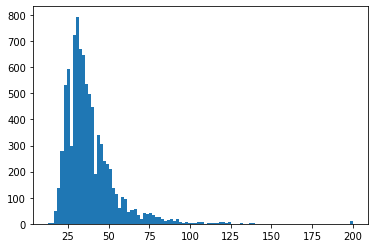

In [75]:
import matplotlib.pyplot as plt

plt.hist(dev_sentence_lengths, bins=100)

## Creating Baseline Neural Network

In [46]:
class FGC_Network(nn.Module):

    def __init__(self):
        
        super(FGC_Network, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-chinese')
        self.linear = nn.Linear(768, 1)

    def forward(self, batch):
        # batch['ids'] = (batch_size, sent_len)
        # batch['segment_ids'] = (batch_size, sent_len)
        # batch['mask_ids'] = = (batch_size, sent_len)
        # output = (batch_size, 1)
        hidden_state, pooler_output = self.bert(batch['ids'], batch['mask_ids'], batch['segment_ids'])
        linear_output = self.linear(pooler_output)
        
        return linear_output

    def loss(self, batch):
        
        loss_fn = nn.BCEWithLogitsLoss()
        output = self.forward(batch)
        target = batch['labels'].float().to(device)
        
        return loss_fn(output, target)
    
    def _predict(self, batch):
        
        output = self.forward(batch)
        scores = torch.sigmoid(output)
        scores = scores.cpu().numpy()[:,0].tolist()
        
        return scores
    
    def predict_fgc(self, batch, threshold=0.5):
        
        scores = self._predict(batch)
        max_i = 0
        max_score = 0
        sp = []
        
        for i, score in enumerate(scores):

            if score > max_score:
                max_i = i
                max_score = score
            if score >= threshold:
                sp.append(i)

        if not sp:
            sp.append(max_i)

        return {'sp': sp, 'sp_scores': scores}

In [ ]:
network = FGC_Network()
network.to(device)

## Training Baseline Model & Evaluating Performance

In [23]:
def optim(nn, num_epochs, lr):
    param_optimizer = list(nn.bert.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    num_epochs = num_epochs
    num_train_optimization_steps = len(dataloader_train) * num_epochs
    optimizer = AdamW(optimizer_grouped_parameters, lr=lr)
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                     num_warmup_steps=int(
                                                         num_train_optimization_steps * 0.1),
                                                     num_training_steps=num_train_optimization_steps)
    return optimizer, scheduler

In [24]:
def _update_sp(metrics, sp_gold, sp_pred):
    tp, fp, fn = 0, 0, 0
        
    for p in sp_pred:
        if p in sp_gold:
            tp += 1
        else:
            fp += 1
    for g in sp_gold:
        if g not in sp_pred:
            fn += 1
            
    precision = 1.0 * tp / (tp + fp) if tp + fp > 0 else 0.0
    recall = 1.0 * tp / (tp + fn) if tp + fn > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0.0
    em = 1.0 if fp + fn == 0 else 0.0
    
    metrics['sp_em'] += em
    metrics['sp_f1'] += f1
    metrics['sp_prec'] += precision
    metrics['sp_recall'] += recall
    
    return precision, recall, f1

In [25]:
def eval_sp_fgc(sp_golds, sp_preds):
    
    metrics = {'sp_em': 0, 'sp_prec': 0, 'sp_recall': 0, 'sp_f1': 0}
    
    assert len(sp_golds) == len(sp_preds)
    
    for sp_gold, sp_pred in zip(sp_golds, sp_preds):
        _update_sp(metrics, sp_gold, sp_pred)
    
    N = len(sp_golds)
    for k in metrics.keys():
        metrics[k] /= N
        metrics[k] = round(metrics[k], 3)
    print(metrics)
    return metrics

In [26]:
def eval_fgc_atype(atype_golds, atype_preds):
    
    pos = 0
    neg = 0
    
    for gold, atype in zip(atype_golds, atype_preds):
        if atype == gold:
            pos += 1
        else:
            neg += 1
    return pos/len(atypes_preds)

In [27]:
def eval(network, dev_batches, current_epoch, sp_golds, avg_loss):
    
    network.eval()
    
    with torch.no_grad():
        sp_preds = []
        
        for batch in tqdm(dev_batches):
            
            out_dct = network.predict_fgc(batch)
            sp_preds.append(out_dct['sp'])
                
              
    metrics = eval_sp_fgc(sp_golds, sp_preds)
    print('epoch %d eval_recall: %.3f eval_f1: %.3f loss: %.3f' % (
            current_epoch, metrics['sp_recall'], metrics['sp_f1'], avg_loss))
        
    torch.save(network.state_dict(), "FGC_release_1.7.13/New_Models/model_epoch{0}_eval_em:{1:.3f}_precision:{2:.3f}_recall:{3:.3f}_f1:{4:.3f}_loss:{5:.3f}.m".format(current_epoch, metrics['sp_em'], metrics['sp_prec'], metrics['sp_recall'], metrics['sp_f1'], avg_loss))
    
    return sp_preds, sp_golds

In [28]:
def train(network, data, dev_batches, num_epochs, lr):
    
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer, scheduler = optim(network, num_epochs, lr)
    
    sp_golds = validation_data['QUESTIONS'].apply(lambda x: x[0]['SHINT_']).tolist()
    
    for current_epoch in range(num_epochs):
        network.train()
        running_loss = 0.0
        for batch in tqdm(data):
            optimizer.zero_grad()
            current_output = network(batch)
            current_target = batch['labels'].to(dtype=torch.float, device=device)
            current_loss = loss_fn(current_output, current_target)

            current_loss.backward()
            torch.nn.utils.clip_grad_norm_(network.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            running_loss += current_loss.item()
            
        learning_rate_scalar = scheduler.get_lr()[0]
        print('lr = %f' % learning_rate_scalar)
        avg_loss = running_loss/len(data)
        print('epoch %d train_loss: %.3f' % (current_epoch, avg_loss))
        eval(network, data, dev_batches, current_epoch, sp_golds, avg_loss)

In [41]:
#train(network, 20, 0.00002) # if you want to run this again, rememebr to add the parameter 'batches'

In [ ]:
trained_network = FGC_Network()
trained_network.load_state_dict(torch.load("Models/baseline_models_with_scheduler/model_epoch8_eval_em:0.198_precision:0.603_recall:0.588_f1:0.545_loss:0.031.m"))

In [216]:
sp_golds = training_data['QUESTIONS'].apply(lambda x: x[0]['SHINT_']).tolist()
batches = eval_preprocessing(training_data, train_dataset)

trained_network.to("cuda")
train_pred, train_obs = eval(trained_network, batches, 0, sp_golds, 0.001)



{'sp_em': 0.902, 'sp_prec': 0.978, 'sp_recall': 0.963, 'sp_f1': 0.966}
epoch 0 eval_recall: 0.963 eval_f1: 0.966 loss: 0.001


In [217]:
sp_golds = validation_data['QUESTIONS'].apply(lambda x: x[0]['SHINT_']).tolist()
dev_batches = eval_preprocessing(validation_data, dev_dataset)
dev_preds, dev_obs = eval(trained_network, dev_batches, 0, sp_golds, 0.001)


{'sp_em': 0.198, 'sp_prec': 0.603, 'sp_recall': 0.588, 'sp_f1': 0.545}
epoch 0 eval_recall: 0.588 eval_f1: 0.545 loss: 0.001


In [218]:
sp_golds = test_data['QUESTIONS'].apply(lambda x: x[0]['SHINT_']).tolist()
test_batches = eval_preprocessing(test_data, test_dataset)
test_preds, test_obds = eval(trained_network, test_batches, 0, sp_golds, 0.001)


{'sp_em': 0.233, 'sp_prec': 0.661, 'sp_recall': 0.573, 'sp_f1': 0.57}
epoch 0 eval_recall: 0.573 eval_f1: 0.570 loss: 0.001


## Training Data Error Analysis

In [234]:
validation_data_with_performance = datapreprocessing(validation_data, True)
training_data_with_performance = datapreprocessing(training_data, True)
test_data_with_performance = datapreprocessing(test_data, True)

In [235]:
training_data_with_performance['train_pred'] = train_pred
training_data_with_performance['train_obs'] = train_obs

In [236]:
correct_sp = []
for i in range(training_data_with_performance.shape[0]):
    para = training_data_with_performance['Sentence_List'][i]
    sen = []
    for index in training_data_with_performance['train_pred'][i]:
        sen.append(para[index])
    correct_sp.append(sen)
training_data_with_performance['Pred_List'] = correct_sp
correct_sp = []
for i in range(training_data_with_performance.shape[0]):
    para = training_data_with_performance['Sentence_List'][i]
    sen = []
    for index in training_data_with_performance['train_obs'][i]:
        sen.append(para[index])
    correct_sp.append(sen)
training_data_with_performance['Obs_List'] = correct_sp

In [237]:
training_data_with_performance.drop(['SE_Index', 'Label', 'train_pred', 'train_obs'], axis=1, inplace=True)

In [238]:
train_mismatch = training_data_with_performance[training_data_with_performance['Pred_List'] != training_data_with_performance['Obs_List']]
train_mismatch

,Question,Sentence_List,Length,Pred_List,Obs_List
1,苏东坡出生于哪一年?,"[嘉佑二年（1057年），, 苏轼才20岁，, 与弟弟苏辙一同进京参加会考，, 苏轼中进士第...",35,[苏轼才20岁，],"[嘉佑二年（1057年），, 苏轼才20岁，]"
2,苏东坡和谁一起进京参加会考?,"[嘉佑二年（1057年），, 苏轼才20岁，, 与弟弟苏辙一同进京参加会考，, 苏轼中进士第...",35,[与弟弟苏辙一同进京参加会考，],"[苏轼才20岁，, 与弟弟苏辙一同进京参加会考，]"
8,在苏东坡被王安石诬陷时，谁为他说话？,"[嘉佑二年（1057年），, 苏轼才20岁，, 与弟弟苏辙一同进京参加会考，, 苏轼中进士第...",35,[范镇极辩苏轼贩盐之诬，],"[范镇极辩苏轼贩盐之诬，, 并愿意退休负责。]"
12,苏东坡哪一年离开海南岛?,"[元祐元年（1086年），, 宋哲宗即位，, 高太皇太后垂帘听政，, 回朝任礼部郎中、中书舍...",32,"[\n绍圣元年（1094年）被哲宗贬谪至惠州、儋州（海南岛）。, 下诏让苏轼北还。]","[\n绍圣元年（1094年）被哲宗贬谪至惠州、儋州（海南岛）。, \n元符三年（1100年）..."
13,苏东坡死于哪一年?,"[元祐元年（1086年），, 宋哲宗即位，, 高太皇太后垂帘听政，, 回朝任礼部郎中、中书舍...",32,[七月二十八日于常州孙氏馆病卒，],"[\n建中靖国元年（1101年），, 七月二十八日于常州孙氏馆病卒，]"
...,...,...,...,...,...
829,青河大学时代在哪一所学校念书?,"[为倾听新住民心声，, 内政部移民署今(18)日下午，, 在台南市举办新住民座谈会，, 有2...",56,"[青河毕业于越南河内国家大学法文系，, 青河得以持续进修，]","[青河毕业于越南河内国家大学法文系，, 青河得以持续进修，, 她不仅取得国立成功大学硕士学位，]"
831,青河的硕士学位在哪一个国家念的?,"[为倾听新住民心声，, 内政部移民署今(18)日下午，, 在台南市举办新住民座谈会，, 有2...",56,"[青河毕业于越南河内国家大学法文系，, 青河得以持续进修，]","[青河毕业于越南河内国家大学法文系，, 青河得以持续进修，, 她不仅取得国立成功大学硕士学位，]"
867,如果我使用了日本买的眼药水却发生过敏红肿，是否可以申请药害救济?,"[「目睭花花，匏仔看做菜瓜」，, 许多民众如果觉得眼睛雾雾时，, 常常会自行购买眼药水来缓解...",39,"[透过网购或国外带回的眼药水，, 并不属于我国合法药物，, 并不适用我国药害救济制度喔!\n...","[透过网购或国外带回的眼药水，, 并不适用我国药害救济制度喔!\n\n 食药署为..."
870,目前在台湾出现的肠病毒有哪几型?,"[国内肠病毒轻症疫情持续上升，, 另新增1例肠病毒71型并发重症病例。, 疾病管制署再次呼吁...",42,"[以感染肠病毒71型为多(28例)，, 其他分别感染肠病毒D68型、克沙奇A6型、A10型(...","[今(2019)年累计37例肠病毒并发重症病例，, 以感染肠病毒71型为多(28例)，, 其..."


#20 (Pred:[9], Actual:[])

Question:「阿拉伯之春」运动中，走上街头的民众的诉求为何? <br>
Predicted SP: 只有突尼西亚成为阿拉伯之春中，<br>
Actual: None

Comment: While the predicted SP is incorrect, I found out that there is supporting evidence in the paragraph. (...要求推翻本国的专制政体的行动)This might be a case of incorrect input.

#70 (Pred:[11], Actual:[])

Question: 第二次签订的北美贸易协定从签署至生效过了几日? <br>
Predicted SP: 美国、墨西哥和加拿大就更新北美自由贸易协定达成一致，<br>
Actual: None

Comment: Same as #20. (美国、加拿大及墨西哥在1992年8月12日签署了关于三国间全面贸易的协议。...，北美自由贸易协议于1994年1月1日正式生效。)

#156 (Pred:[1], Actual:[])

Question: 聊天机器人仰赖哪些方法让回答愈来愈准确? <br>
Predicted SP: 麻省理工学院（MIT）人工智慧实验室早在1966年即研发出名为「Eliza」的机器人， <br>
Actual: None <br>

Comment: Same (聊天机器人的作答准确度要透过程式化的方法改善)

#284 (Pred:[3], Actual:[])

Question: 不可再生能源的意义是什么？ <br>
Predicted SP: 许多这些形式可以很容易转化为另一种的帮助下， <br>
Actual: None <br>

Comment: Same (是无法经过短时间内再生的能源，而且它们的消耗速度远远超过它们再生的速度)

#324 (Pred:[4], Actual:[])

Question: 伊甸基金會成立的宗旨為何? <br>
Predicted SP: 因著上帝的呼召及一颗爱身心障碍者的同理心，<br>
Actual: None <br>

Comment: No SP in the paragraph. But I think SP is pretty close to being a supporting evidence. This 
must be a borderline case.

#370 (Pred:[12,25], Actual:[25])

Question: 三大健康照护体系保险制度中，政府涉入程度低的是哪一种？<br>
Predicted SP: 公医制（政府介入最多）：以英国为代表。 AND 自由市场（政府一般不介入）：以2013年前的美国为代表。<br>
Actual: 公医制（政府介入最多）：以英国为代表。<br>

Comment: I think this is a very reasonable mismatch. As two supporting evidences are very similar
syntax-wise but drastically different in meaning.

#371 (Pred:[12,25], Actual:[12])

Question: 三大健康照護體系保險制度中，政府涉入程度高的是哪一種？ <br>
Predicted SP: 公医制（政府介入最多）：以英国为代表。 AND 自由市场（政府一般不介入）：以2013年前的美国为代表。<br>
Actual: 公医制（政府介入最多）：以英国为代表。<br>

Comment: Same as #370

#395 (Pred:[10], Actual:[])

Question: 熬夜是否能减低得到癌症的风险? <br>
Predicted SP: 皆强烈建议减少或避免动物性食品摄取， <br>
Actual: None <br>

Comment: Another potential case of incorrect input. In the paragraph I found this sentence (所以防癌守则：...，注重睡眠品质)

#449 (Pred:[2], Actual:[])

Question: 高屏地区国庆烟火试放管制时间是从晚上几点开始？ <br>
Predicted SP: 屏东县政府表示24号当天屏东河滨公园将管制不开放， <br>
Actual: None <br>

Comment: Another similar case. This time I strongly believe this is an incorrect input. 
当晚7时并会进行全面清场 <- This is sufficient to be a supporting evidence

#502 (Pred:[7], Actual:[])

Question: 为何圣伯多禄大殿只能重建不能整修就好? <br>
Predicted SP: 教宗犹利二世决定重建圣伯多禄大殿 <br>
Actual: None 

Comment: Another similar case. (无疑再改动有机会让建筑倒塌)

#630 (Pred:[62], Actual:[])

Question: 毛笔、铅笔、钢笔，这三种笔中哪个笔尖的硬度高？ <br>
Predicted SP: 更进一步看：我们无论使用那一种笔，<br>
Actual: None <br>

Comment: Again, I think this counts as a supporting evidence (钢笔的笔尖用金属制成，弹性大，硬度高)

#731 (Pred:[9], Actual:[])

Question: 为什么古埃及人要把死人做成木乃伊? <br>
Predicted SP: 是做什么用的呢？ <br>
Actual: None <br>

Comment: I think this counts (古埃及人相信：人死后只要把遗体保存好，就可以在另一个世界得到永生。)

#874 (Pred:[22], Actual:[])

Question: 要如何降低肠病毒的传播风险？
Predicted SP: 今(2019)年累计37例肠病毒并发重症病例，
Actual: None

Comment: No doubt, these are supporting evidences (应加强居家环境、教室及游乐设施等的通风、整洁与消毒，并教导学童落实「湿、搓、冲、捧、擦」正确洗手步骤，及生病在家休息等良好卫生观念，)

## Validation Data Error Analysis

In [239]:
validation_data_with_performance['dev_pred'] = dev_preds
validation_data_with_performance['dev_obs'] = dev_obs

In [240]:
correct_sp = []
for i in range(validation_data_with_performance.shape[0]):
    para = validation_data_with_performance['Sentence_List'][i]
    sen = []
    for index in validation_data_with_performance['dev_pred'][i]:
        sen.append(para[index])
    correct_sp.append(sen)
validation_data_with_performance['Pred_List'] = correct_sp
correct_sp = []
for i in range(validation_data_with_performance.shape[0]):
    para = validation_data_with_performance['Sentence_List'][i]
    sen = []
    for index in validation_data_with_performance['dev_obs'][i]:
        sen.append(para[index])
    correct_sp.append(sen)
validation_data_with_performance['Obs_List'] = correct_sp

In [241]:
validation_data_with_performance.drop(['SE_Index', 'Label'], axis=1, inplace=True)

In [242]:
validation_data_with_performance.drop(['Sentence_List', 'dev_pred', 'dev_obs'], axis=1, inplace=True)

In [243]:
dev_mismatch = validation_data_with_performance[validation_data_with_performance['Obs_List'] != validation_data_with_performance['Pred_List']]

In [244]:
dev_mismatch

,Question,Length,Pred_List,Obs_List
0,苏东坡在中国历史上，是哪一个朝代的人？,36,[苏轼（1037年1月8日－1101年8月24日），],"[苏轼（1037年1月8日－1101年8月24日），, 北宋时著名的文学家、政治家、艺术家、..."
1,苏东坡是中国哪个省份的人？,36,"[苏轼（1037年1月8日－1101年8月24日），, 眉州眉山（今四川省眉山市）人，]","[苏轼（1037年1月8日－1101年8月24日），, 眉州眉山（今四川省眉山市）人，, 号..."
2,苏东坡的爸爸叫什么名字?,36,[苏轼（1037年1月8日－1101年8月24日），],"[苏轼（1037年1月8日－1101年8月24日），, 号东坡居士、铁冠道人。, 苏轼的散文..."
3,苏文忠公指的是谁?,36,[苏轼（1037年1月8日－1101年8月24日），],"[苏轼（1037年1月8日－1101年8月24日），, 加赐谥号文忠，]"
4,《苏文忠公全集》是由何人编纂？,36,"[苏轼（1037年1月8日－1101年8月24日），, 编有《苏文忠公全集》。]","[宋人王宗稷收其作品，, 编有《苏文忠公全集》。]"
...,...,...,...,...
237,内政部消防署提出防范纵火方法「三从四得」，请问是哪「三从」?,33,"[可以依照「三从四得」的方法防范纵火，, 民众可以依照「三从四得」的方法，, 防范居家或社区...","[\n内政部表示，, 民众可以依照「三从四得」的方法，, 三从就是「从消除死角做起」、「从守..."
238,内政部消防署提出防范纵火方法「三从四得」，请问是哪「四得」?,33,"[可以依照「三从四得」的方法防范纵火，, 民众可以依照「三从四得」的方法，, 防范居家或社区...","[\n内政部表示，, 民众可以依照「三从四得」的方法，, 四得就是「可疑状况要认得」、「大门..."
244,这起诈骗案件的受害人是男性还是女性？,39,"[经查系单身女子曾女数月前上网至「异性」交友网站，, 被骗曾姓女子信以为真，, 遂依指示至南...","[南港分局南港派出所于108年11月5日接获民众报案称其友人疑似遭受诈骗案件，, 经查系单身..."
245,这起诈骗案件的诈骗金额是多少？,39,[警方查证后确认系一椿网路交友爱情诈骗案件，],"[南港分局南港派出所于108年11月5日接获民众报案称其友人疑似遭受诈骗案件，, 当日接获该..."


## Improving Baseline Neural Network

In [29]:
class FGC_LSTM_Network(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        
        super(FGC_LSTM_Network, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-chinese')
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        self.linear = nn.Linear(hidden_size * 2, 1)
        # (H-state and c_state must be converted into 3d in forward function)
    def forward(self, batch):
        # batch['ids'] = (batch_size*number of sentence, sent_len)
        # batch['segment_ids'] = (batch_size*number of sentence, sent_len)
        # batch['mask_ids'] = (batch_size*number of sentence, sent_len)
        # pooler_output = (batch_size, 768)
        # hidden_state = (batch_size, sent_len, 768)
        # output = (batch_size, 1)
        
        h0 = torch.zeros(self.num_layers*2, batch['ids'].shape[0], self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers*2, batch['ids'].shape[0], self.hidden_size).to(device)
        
        batch_size = batch['ids'].shape[0]
        max_sent_size = batch['ids'].shape[2]
        
        ids = batch['ids'].view(-1, max_sent_size)
        mask_ids = batch['mask_ids'].view(-1, max_sent_size)
        segment_ids = batch['segment_ids'].view(-1, max_sent_size)
        
        hidden_state, pooler_output = self.bert(ids, mask_ids, segment_ids)
        pooler_output = pooler_output.view(batch_size, -1, 768)
        
        lstm_output, (hn, cn) = self.lstm(pooler_output, (h0, c0))
        linear_output = self.linear(lstm_output)
        
        return linear_output
    def loss(self, batch):
        
        loss_fn = nn.BCEWithLogitsLoss()
        output = self.forward(batch)
        target = batch['labels'].float().to(device)
        
        return loss_fn(output, target)
    
    def _predict(self, batch):
        
        output = self.forward(batch)
        scores = torch.sigmoid(output)
        scores = scores.cpu().numpy().tolist()
        
        return scores
    
    def predict_fgc(self, batch, threshold=0.5):
        
        
        scores = self._predict(batch)
        max_i = 0
        max_score = 0
        sp = []
    
        for i, score in enumerate(scores[0]):

            if score[0] > max_score:
                max_i = i
                max_score = score[0]
            if score[0] >= threshold:
                sp.append(i)

        if not sp:
            sp.append(max_i)
        # This is to ensure there's no empty supporting evidences
        if not sp:
            sp.append(max_i)
        return {'sp': sp, 'sp_scores': scores}

In [30]:
new_network = FGC_LSTM_Network(768, 768, 2)

I0723 08:26:16.695196 140283865257792 configuration_utils.py:152] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-config.json from cache at /root/.cache/torch/transformers/8a3b1cfe5da58286e12a0f5d7d182b8d6eca88c08e26c332ee3817548cf7e60a.f12a4f986e43d8b328f5b067a641064d67b91597567a06c7b122d1ca7dfd9741
I0723 08:26:16.701801 140283865257792 configuration_utils.py:169] Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 0,
  

In [31]:
new_network.to(device)

FGC_LSTM_Network(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
   

## Training Improved Model & Evaluating Performance

In [32]:
def new_model_eval(network, dev_batches, current_epoch, sp_golds, avg_loss):
    
    network.eval()
    with torch.no_grad():
        sp_preds = []
        
        for batch in tqdm(dev_batches):
            out_dct= network.predict_fgc(batch)
            sp_preds.append(out_dct['sp'])
                
              
    metrics = eval_sp_fgc(sp_golds, sp_preds)
    print('epoch %d eval_recall: %.3f eval_f1: %.3f loss: %.3f' % (
            current_epoch, metrics['sp_recall'], metrics['sp_f1'], avg_loss))
        
    torch.save(network.state_dict(), "New_Models/model_epoch{0}_eval_em:{1:.3f}_precision:{2:.3f}_recall:{3:.3f}_f1:{4:.3f}_loss:{5:.3f}.m".format(current_epoch, metrics['sp_em'], metrics['sp_prec'], metrics['sp_recall'], metrics['sp_f1'], avg_loss))
    
    return sp_preds, sp_golds

In [33]:
def train(network, data, dev_batches, num_epochs, lr):
    
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer, scheduler = optim(network, num_epochs, lr)
    
    sp_golds = validation_data['QUESTIONS'].apply(lambda x: x[0]['SHINT_']).tolist()
    
    for current_epoch in range(num_epochs):
        network.train()
        running_loss = 0.0
        for batch in tqdm(data):
            optimizer.zero_grad()
            current_output = network(batch)
            current_target = batch['labels'].to(dtype=torch.float, device=device)
            current_loss = loss_fn(current_output, current_target)

            current_loss.backward()
            torch.nn.utils.clip_grad_norm_(network.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            running_loss += current_loss.item()
            
        learning_rate_scalar = scheduler.get_lr()[0]
        print('lr = %f' % learning_rate_scalar)
        avg_loss = running_loss/len(data)
        print('epoch %d train_loss: %.3f' % (current_epoch, avg_loss))
        new_model_eval(network, dev_batches, current_epoch, sp_golds, avg_loss)

In [33]:
new_dev_batches = window_sentence_preprocessing(validation_data, dev_dataset, 10)
testing_dev_batches = DataLoader(new_dev_batches, batch_size=2, shuffle = False, collate_fn = collate_3d)

In [34]:

a = eval_preprocessing(validation_data, dev_dataset)

In [35]:
for data in a:
    data['ids'] = data['ids'].unsqueeze(0)
    data['mask_ids'] = data['mask_ids'].unsqueeze(0)
    data['segment_ids'] = data['segment_ids'].unsqueeze(0)
    data['labels'] = data['labels'].unsqueeze(0)

In [36]:
a[0]['ids']

tensor([[[ 101, 5722,  691,  ...,    0,    0,    0],
         [ 101, 5722,  691,  ...,    0,    0,    0],
         [ 101, 5722,  691,  ...,    0,    0,    0],
         ...,
         [ 101, 5722,  691,  ..., 7674, 8039,  102],
         [ 101, 5722,  691,  ...,    0,    0,    0],
         [ 101, 5722,  691,  ...,    0,    0,    0]]], device='cuda:0')

In [43]:
#new_model_eval(new_network, a, 0, validation_data['QUESTIONS'].apply(lambda x: x[0]['SHINT_']).tolist(), 0)

In [154]:
iter(new_dev_batches).next()['ids'].shape

torch.Size([2, 10, 48])

In [62]:
sc = new_network._predict(iter(dataloader_train_3d).next())

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [78]:
for batch in sc.cpu().detach().numpy().tolist():
    for instance in batch:
        print("wang:", instance[0])


wang: 0.5312566161155701
wang: 0.521264910697937
wang: 0.5146143436431885
wang: 0.5118281841278076
wang: 0.5112723112106323
wang: 0.5121220946311951
wang: 0.5141165256500244
wang: 0.5170711278915405
wang: 0.5210497379302979
wang: 0.5272684693336487
wang: 0.47272515296936035
wang: 0.4636615812778473
wang: 0.4688776731491089
wang: 0.48730167746543884
wang: 0.4750833213329315
wang: 0.4615252912044525
wang: 0.46430811285972595
wang: 0.4680739641189575
wang: 0.48677390813827515
wang: 0.49829909205436707


In [ ]:
train(new_network, dataloader_train_3d, a, 20, 0.00002)


lr = 0.000005
epoch 0 train_loss: 0.479



{'sp_em': 0.04, 'sp_prec': 0.259, 'sp_recall': 0.132, 'sp_f1': 0.168}
epoch 0 eval_recall: 0.132 eval_f1: 0.168 loss: 0.479


In [55]:
for batch in dataloader_train_3d:
    print(batch)
    break

{'ids': tensor([[[ 101, 5031, 2190,  ...,    0,    0,    0],
         [ 101, 5031, 2190,  ...,    0,    0,    0],
         [ 101, 5031, 2190,  ..., 2785, 8024,  102],
         ...,
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]],

        [[ 101, 1762,  779,  ...,    0,    0,    0],
         [ 101, 1762,  779,  ...,    0,    0,    0],
         [ 101, 1762,  779,  ...,    0,    0,    0],
         ...,
         [ 101, 1762,  779,  ...,    0,    0,    0],
         [ 101, 1762,  779,  ...,    0,    0,    0],
         [ 101, 1762,  779,  ...,    0,    0,    0]]], device='cuda:0'), 'mask_ids': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]